## Import Libraries

In [1]:
working_dir = "../."
dataset_h5_path = r"C:\Users\andri\Progetti\lus-dl-framework\data\iclus\dataset.h5"
hospitaldict_path = r"C:\Users\andri\Progetti\lus-dl-framework\data\iclus\hospitals-patients-dict.pkl"
# dataset_h5_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5"
# hospitaldict_path = "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl"
libraries_dir = working_dir + "/libraries"

In [4]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
import pickle
import sys
import timm
from PIL import Image

import matplotlib.pyplot as plt
import torchvision 
import numpy as np
import pandas as pd
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from kornia import tensor_to_image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from lightning.pytorch.callbacks import EarlyStopping, DeviceStatsMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from torchsummary import summary


sys.path.append(working_dir)
from data_setup import HDF5Dataset, FrameTargetDataset, DataAugmentation
from lightning_modules.LUSModelLightningModule import LUSModelLightningModule
from lightning_modules.LUSDataModule import LUSDataModule


os.chdir(working_dir)
os.getcwd()



'c:\\Users\\andri\\Progetti\\lus-dl-framework'

In [5]:
# Training settings
batch_size = 16
epochs = 20
lr = 1e-4
gamma = 0.7
seed = 21
train_ratio = 0.7
num_workers = 0

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
device = torch.device('cuda')
device

device(type='cuda')

## Load Data

In [8]:
dataset = HDF5Dataset(dataset_h5_path)

train_indices_path = os.path.dirname(dataset_h5_path) + f"/train_indices_{train_ratio}.pkl"
test_indices_path = os.path.dirname(dataset_h5_path) + f"/test_indices_{train_ratio}.pkl"

Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.


In [9]:
if os.path.exists(train_indices_path) and os.path.exists(test_indices_path):
    print("Loading pickled indices")
    with open(train_indices_path, 'rb') as train_pickle_file:
        train_indices = pickle.load(train_pickle_file)
    with open(test_indices_path, 'rb') as test_pickle_file:
        test_indices = pickle.load(test_pickle_file)
    # Create training and test subsets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)  
else:
    train_subset, test_subset, split_info, train_indices, test_indices = dataset.split_dataset(hospitaldict_path, 
                                                              seed, 
                                                              train_ratio)
    print("Pickling sets...")
    
    # Pickle the indices
    with open(train_indices_path, 'wb') as train_pickle_file:
        pickle.dump(train_indices, train_pickle_file)
    with open(test_indices_path, 'wb') as test_pickle_file:
        pickle.dump(test_indices, test_pickle_file)

Loading pickled indices


In [10]:
# test_subset_size = train_ratio/2
# test_subset = Subset(test_subset, range(int(test_subset_size * len(test_indices))))
# test_subset

In [11]:
train_dataset = FrameTargetDataset(train_subset)
test_dataset = FrameTargetDataset(test_subset)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 40057
Test size: 18867


In [12]:
transform = DataAugmentation()

# train_dataset.set_transform(preprocess)
# test_dataset.set_transform(preprocess)

## Dataloaders

In [13]:

lus_data_module = LUSDataModule(train_dataset, 
                                test_dataset, 
                                num_workers, 
                                batch_size)

In [14]:
def collate_fn(examples):
    frames = torch.stack([example[0] for example in examples])  # Extract the preprocessed frames
    scores = torch.tensor([example[1] for example in examples])  # Extract the scores
    # return {"pixel_values": frames, "labels": scores}
    return (frames, scores)

train_dataloader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers=0,
                          pin_memory=True,
                          collate_fn=collate_fn, shuffle=False)

test_dataloader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          pin_memory=True,
                          collate_fn=collate_fn)

## Batch Visualizations

c:\Users\andri\anaconda3\envs\lus_dl\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
c:\Users\andri\anaconda3\envs\lus_dl\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(ant

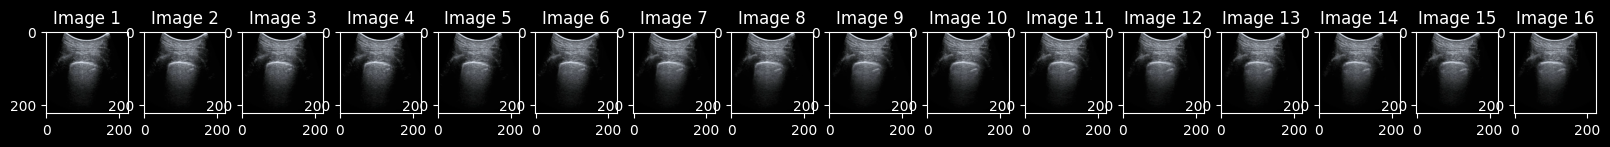

In [15]:
def show_single_batch(data_loader, batch_idx, win_size=(20, 20)):
    # Extract the specific batch by indexing the DataLoader
    for i, (imgs, labels) in enumerate(data_loader):
        if i == batch_idx:
            # Create a subplot for each image in the batch
            num_images = len(imgs)
            plt.figure(figsize=win_size)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(tensor_to_image(imgs[j]))  # Convert the tensor to an image
                plt.title(f"Image {j+1}")

            plt.show()
            break
# To display a specific batch (e.g., batch index 0) from the training DataLoader
show_single_batch(test_dataloader, batch_idx=6)

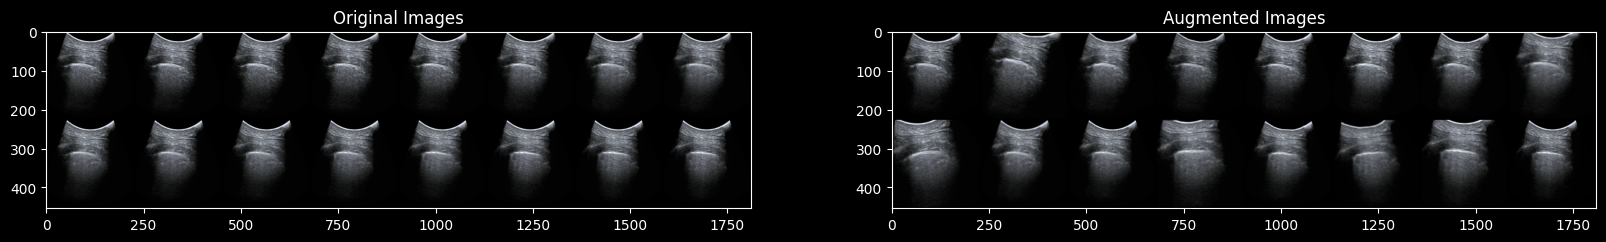

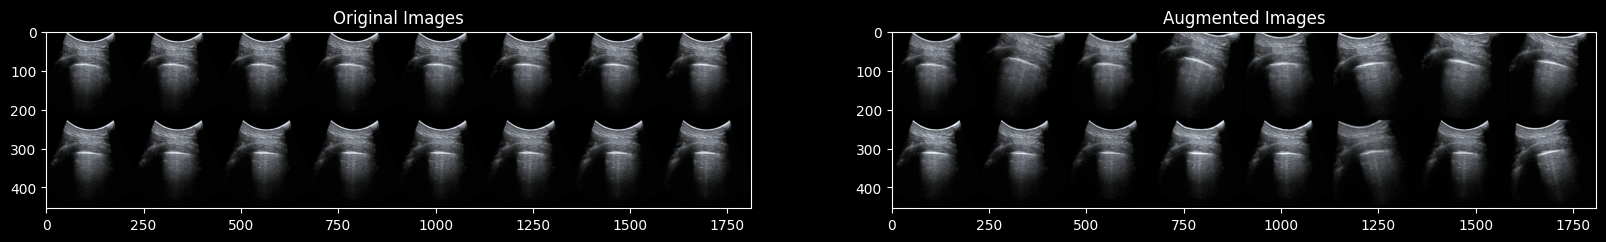

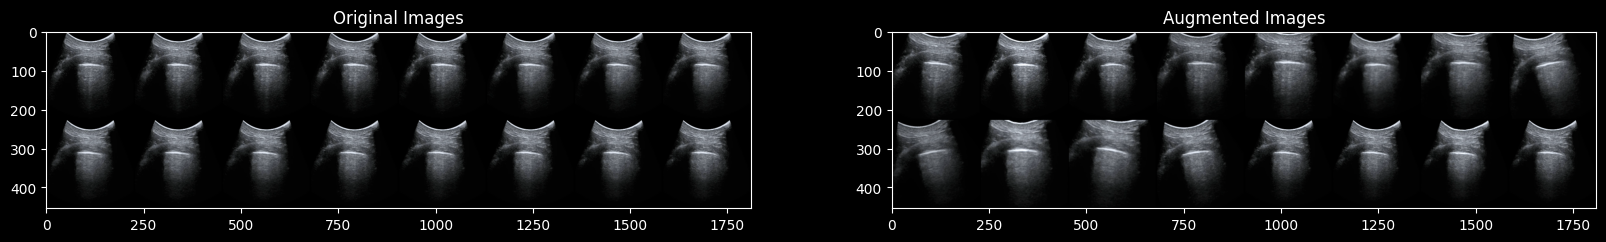

In [16]:

def show_batch(data_loader, num_batches=1, win_size=(20, 20)):
    def _to_vis(data):
        # Ensure that pixel values are in the valid range [0, 1]
        data = torch.clamp(data, 0, 1)
        return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

    for batch_num, (imgs, labels) in enumerate(data_loader):
        if batch_num >= num_batches:
            break
        
        # Apply data augmentation to the batch (you need to define DataAugmentation function)
        imgs_aug = transform(imgs)

        # Create subplots for original and augmented images
        plt.figure(figsize=win_size)
        plt.subplot(1, 2, 1)
        plt.imshow(_to_vis(imgs))
        plt.title("Original Images")

        plt.subplot(1, 2, 2)
        plt.imshow(_to_vis(imgs_aug))
        plt.title("Augmented Images")

        plt.show()

# To display one batch from the training DataLoader
show_batch(test_dataloader, num_batches=3)

# Model

In [92]:
timm.list_models('bot*', pretrained=True)
timm_model = 'botnet26t_256.c1_in1k'
# timm_model = 'beit_base_patch16_224.in22k_ft_in22k'
# timm_model = 'resnet18.a3_in1k'


In [93]:
which_model = "timm_bot"
pretrained = True
optimizer = "sgd"
lr = 0.0001
batch_size = 16
num_workers = 0


hyperparameters = {
  "num_classes": 4,
  "optimizer": "sgd",
  "lr": 0.0001,
  "weight_decay": 0.0001,    
  "momentum": 0.01
#   "configuration": configuration
}
table_data = []
table_data.append(["MODEL HYPERPARAMETERS"])
table_data.append(["model", which_model])
for key, value in hyperparameters.items():
    if key not in ["train_dataset", "test_dataset"]:
      table_data.append([key, value])

table = tabulate(table_data, headers="firstrow", tablefmt="fancy_grid")
print(table)

╒══════════════╤═════════════════════════╕
│              │ MODEL HYPERPARAMETERS   │
╞══════════════╪═════════════════════════╡
│ model        │ timm_bot                │
├──────────────┼─────────────────────────┤
│ num_classes  │ 4                       │
├──────────────┼─────────────────────────┤
│ optimizer    │ sgd                     │
├──────────────┼─────────────────────────┤
│ lr           │ 0.0001                  │
├──────────────┼─────────────────────────┤
│ weight_decay │ 0.0001                  │
├──────────────┼─────────────────────────┤
│ momentum     │ 0.01                    │
╘══════════════╧═════════════════════════╛


# Trainer

## Callbacks

In [28]:
# Callbacks
# -EarlyStopping
early_stop_callback = EarlyStopping(
    monitor='training_loss',
    patience=5,
    strict=False,
    verbose=False,
    mode='min'
)

# -Logger configuration
name_trained = "pretrained_" if pretrained==True else ""
model_name = f"{name_trained}{which_model}/{optimizer}/{lr}_{batch_size}"
logger = TensorBoardLogger("tb_logs", name=model_name)

# -Checkpointing
#   Checkpoints directory
checkpoint_dir = f"{working_dir}/checkpoints/{model_name}"
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir, 
                                      save_top_k=3,
                                      mode="min",
                                      monitor="training_loss",
                                      save_last=True,
                                      verbose=True)

callbacks = [DeviceStatsMonitor(), 
            early_stop_callback,
             checkpoint_callback]
checkpoint_dir

NameError: name 'pretrained' is not defined

In [29]:
logger.log_dir

NameError: name 'logger' is not defined

In [96]:
accelerator = "cuda"
device = torch.device(accelerator)
max_epochs = 10
precision = 32
accumulate_grad_batches = 1

trainer_args = {
    "accelerator": accelerator,
    # "strategy": "ddp" if accelerator == "gpu" else "auto",
    "max_epochs": max_epochs,
    "callbacks": callbacks,
    "precision": precision,
    "accumulate_grad_batches": accumulate_grad_batches,
    "logger": logger
}

# Trainer 
trainer = Trainer(**trainer_args,
                #   detect_anomaly=True,
                #   overfit_batches=0.01,
                #   val_check_interval=0.25,
                #   gradient_clip_val=0.1,
                  default_root_dir = checkpoint_dir)

table_data = []
table_data.append(["TRAINER ARGUMENTS"])
for key, value in trainer_args.items():
    if key not in ["callbacks", "logger"]:
        table_data.append([key, value])

table = tabulate(table_data, headers="firstrow", tablefmt="fancy_grid")
print("\n\n" + table)
print(f"Model checkpoints directory is {checkpoint_dir}")
print("\n\n")

print("\n\n" + "-" * 20)
print("Trainer Callbacks:")
print("-" * 20 + "\n\n")
for callback in trainer.callbacks:
    print(f"- {type(callback).__name__}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs




╒═════════════════════════╤═════════════════════╕
│                         │ TRAINER ARGUMENTS   │
╞═════════════════════════╪═════════════════════╡
│ accelerator             │ cuda                │
├─────────────────────────┼─────────────────────┤
│ max_epochs              │ 10                  │
├─────────────────────────┼─────────────────────┤
│ precision               │ 32                  │
├─────────────────────────┼─────────────────────┤
│ accumulate_grad_batches │ 1                   │
╘═════════════════════════╧═════════════════════╛
Model checkpoints directory is .././checkpoints/pretrained_timm_bot/sgd/0.0001_16





--------------------
Trainer Callbacks:
--------------------


- DeviceStatsMonitor
- EarlyStopping
- TQDMProgressBar
- ModelSummary
- ModelCheckpoint


## Checkpoints

In [97]:
def check_checkpoint(checkpoint_path):

    print("Checkpoint mode activated...\n")

    if (checkpoint_path == "best"):
        print("Loading BEST checkpoint...\n")

    if (checkpoint_path == "last"):
        print("Loading LAST checkpoint...\n")

    else:
    # Check if checkpoint file exists
        if not os.path.isfile(checkpoint_path):
            print(f"Checkpoint file '{checkpoint_path}' does not exist. Exiting...")
            exit()

    print(f"Loading checkpoint from PATH: '{checkpoint_path}'...\n")

# Evaluation

### Architecture summary

In [129]:
checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\pretrained_timm_bot\sgd\0.0001_32\epoch=2-step=951.ckpt"
# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\pretrained_timm_bot\sgd\0.0001_32\epoch=29-step=37560.ckpt"
# checkpoint_path = r"C:\Users\andri\Progetti\lus-dl-framework\checkpoints\pretrained_timm_bot\sgd\5e-05_32\epoch=39-step=50080.ckpt"
check_checkpoint(checkpoint_path)
model = LUSModelLightningModule.load_from_checkpoint(checkpoint_path)
model

Checkpoint mode activated...

Loading checkpoint from PATH: 'C:\Users\andri\Progetti\lus-dl-framework\checkpoints\pretrained_timm_bot\sgd\0.0001_32\epoch=2-step=951.ckpt'...



Using pretrained weights: True




LUSModelLightningModule(
  (model): ByobNet(
    (stem): Stem(
      (conv1): ConvNormAct(
        (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv3): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
  

In [130]:
# Freeze all layers except the head
for name, param in model.named_parameters():
    if 'head' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Verify which layers are frozen and which are trainable
for name, param in model.named_parameters():
    print(f'Parameter: {name}, Requires Gradient: {param.requires_grad}')

Parameter: model.stem.conv1.conv.weight, Requires Gradient: False
Parameter: model.stem.conv1.bn.weight, Requires Gradient: False
Parameter: model.stem.conv1.bn.bias, Requires Gradient: False
Parameter: model.stem.conv2.conv.weight, Requires Gradient: False
Parameter: model.stem.conv2.bn.weight, Requires Gradient: False
Parameter: model.stem.conv2.bn.bias, Requires Gradient: False
Parameter: model.stem.conv3.conv.weight, Requires Gradient: False
Parameter: model.stem.conv3.bn.weight, Requires Gradient: False
Parameter: model.stem.conv3.bn.bias, Requires Gradient: False
Parameter: model.stages.0.0.shortcut.conv.weight, Requires Gradient: False
Parameter: model.stages.0.0.shortcut.bn.weight, Requires Gradient: False
Parameter: model.stages.0.0.shortcut.bn.bias, Requires Gradient: False
Parameter: model.stages.0.0.conv1_1x1.conv.weight, Requires Gradient: False
Parameter: model.stages.0.0.conv1_1x1.bn.weight, Requires Gradient: False
Parameter: model.stages.0.0.conv1_1x1.bn.bias, Requires

In [128]:
model.model

ByobNet(
  (stem): Stem(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 

In [99]:
# Display some checkpoint information
print("Checkpoint Information:")
print(f"Checkpoint Path: {checkpoint_path}")
print(f"Hyperparameters: {model.hparams}")
print(f"Trained on Device: {model.device}")

# You can access and print more specific information as needed
# For example, model hyperparameters, optimizer state, etc.

# Access model's state_dict (model weights)
model_state_dict = model.state_dict()
print("Model State Dictionary:")
print(model_state_dict)


Checkpoint Information:
Checkpoint Path: C:\Users\andri\Progetti\lus-dl-framework\checkpoints\pretrained_timm_bot\sgd\0.0001_32\epoch=2-step=951.ckpt
Hyperparameters: "hparams":    {'num_classes': 4, 'optimizer': 'sgd', 'lr': 0.0001, 'weight_decay': 0.0001, 'momentum': 0.01}
"model_name": timm_bot
"pretrained": True
Trained on Device: cuda:0
Model State Dictionary:
OrderedDict([('model.stem.conv1.conv.weight', tensor([[[[ 9.1877e-02, -1.2149e-01,  1.5898e-01],
          [ 5.3466e-01, -1.4139e+00,  7.3038e-01],
          [ 7.0008e-01, -1.1759e+00,  5.0057e-01]],

         [[ 2.3080e-01, -1.5232e-01,  2.3786e-01],
          [ 9.4993e-01, -2.0985e+00,  8.1799e-01],
          [ 1.0843e+00, -1.7375e+00,  6.0759e-01]],

         [[ 1.1126e-01, -1.2503e-01,  2.1286e-02],
          [ 4.0246e-01, -9.7993e-01,  5.3886e-01],
          [ 4.7071e-01, -7.7477e-01,  3.7021e-01]]],


        [[[-1.6723e-01, -6.0556e-01, -4.8723e-01],
          [ 9.5489e-02,  9.8603e-01,  1.6179e+00],
          [ 3.408

### Feature maps extraction

In [100]:
import torch

class BoTNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(BoTNetFeatureExtractor, self).__init__()
        # Extract the layers that you want to get feature maps from
        self.features = nn.Sequential(
            model.model.stem,  # Stem layers
            model.model.stages[0],  # First stage (you can add more stages if needed)
            model.model.stages[1],  # Second stage (you can add more stages if needed)
            model.model.stages[2],  # Third stage (you can add more stages if needed)
            model.model.stages[3]  # Fourth stage (you can add more stages if needed)
        )
        self.final_conv = model.model.final_conv  # The final convolutional layer

    def forward(self, x):
        # Pass the input through the selected layers
        feature_maps = self.features(x)
        return feature_maps
    
# Define a function to visualize feature maps
def visualize_feature_maps(feature_maps, num_columns=8, figsize=(16, 16)):
    batch_size, num_features, height, width = feature_maps.shape
    num_rows = (num_features + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)

    for i in range(num_features):
        row = i // num_columns
        col = i % num_columns
        ax = axes[row, col]
        feature_map = feature_maps[0, i].cpu().detach().numpy()  # Extract and convert to NumPy
        ax.imshow(feature_map, cmap='viridis')  # Choose a colormap (e.g., 'viridis')
        ax.axis('off')

    # Hide any remaining empty subplots
    for i in range(num_features, num_columns * num_rows):
        row = i // num_columns
        col = i % num_columns
        fig.delaxes(axes[row, col])

    plt.show()

In [101]:
# image_idx = 1000
# image = test_dataset[image_idx][0].to(device).unsqueeze(0)

# feature_extractor = BoTNetFeatureExtractor(model)
# feature_maps = feature_extractor(image)

# feature_maps.shape

# # Visualize the feature maps
# visualize_feature_maps(feature_maps, num_columns=8)

### Activation maps

torch.Size([1, 256, 64, 64])


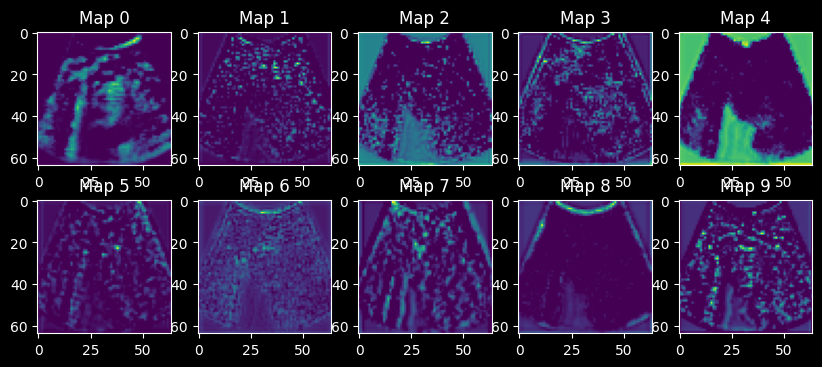

In [102]:
import math

def extract_activation_maps(model, input_image, layer_name):

    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output
        return hook

    # Register the hook on the specified layer
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(get_activation(layer_name))

    # Forward pass to compute activation maps
    with torch.no_grad():
        model(input_image)

    # Remove the hook
    hook.remove()

    # Return the activation maps
    return activations[layer_name]


def plot_activation_maps(activation_maps, num_maps_to_plot=10, start_idx=0):
    num_maps = activation_maps.size(1)  # Get the total number of activation maps
    num_rows = math.ceil(num_maps_to_plot / 5)  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, 5, figsize=(10, 2 * num_rows))
    axes = axes.ravel()

    for i in range(num_maps_to_plot):
        if i < num_maps:
            # Extract a single activation map
            activation_map = activation_maps[0, (start_idx+i), :, :].cpu().detach().numpy()
            axes[i].imshow(activation_map, cmap='viridis')
            axes[i].set_title(f'Map {start_idx+i}')
        else:
            # Hide any empty subplots
            fig.delaxes(axes[i])

    plt.show()

image_idx = 5000
image = test_dataset[image_idx][0].to(device).unsqueeze(0)

layer = "model.stages.0"

activation_maps = extract_activation_maps(model, image, layer)

print(activation_maps.shape)
plot_activation_maps(activation_maps, num_maps_to_plot=10, start_idx=0)

## CAM

In [103]:
model.eval()

LUSModelLightningModule(
  (model): ByobNet(
    (stem): Stem(
      (conv1): ConvNormAct(
        (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvNormAct(
        (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (conv3): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
  

In [104]:
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
import cv2
import PIL

def generate_and_display_CAM(image, cam_model, target_layers, target_class=None):
    
    # Instantiate the GradCAM model
    cam = GradCAM(model=cam_model, target_layers=target_layers)
    
    # Prepare the input tensor
    input_tensor = image.unsqueeze(0)
    
    # Convert the input tensor to a numpy image
    img = np.float32(transforms.ToPILImage()(image)) / 255
    if target_class is not None:
        targets=[ClassifierOutputTarget(target_class)]
    else:
        targets=None
    # targets = [0, 1, 2, 3]
    # Generate CAM
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    
    # Show CAM on the image
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    
    # Convert CAM to BGR format for display
    cam = np.uint8(255 * grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    
    # Display the original image and the associated CAM
    images = np.hstack((np.uint8(255 * img), cam_image))
    return Image.fromarray(images)


Idx: 1800, Target: 2, Predicted: 0


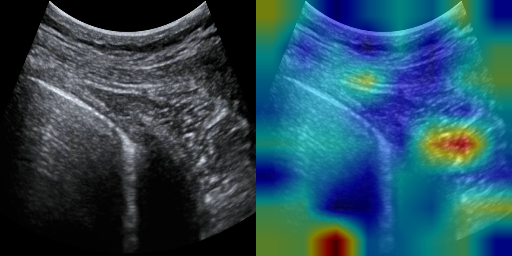

In [105]:
# Load the image tensor
image_idx = 1800
image = test_dataset[image_idx][0].to(device)

# Class to target
target_class = None

# Specify the target layer for CAM
target_layers = [model.model.final_conv]


# Usage
displayed_image = generate_and_display_CAM(image, model, target_layers, target_class)
print(f"Idx: {image_idx}, Target: {test_dataset[image_idx][1]}, Predicted: {model(image.unsqueeze(0))[0].argmax()}")
displayed_image

In [106]:
len(test_dataset)

18867

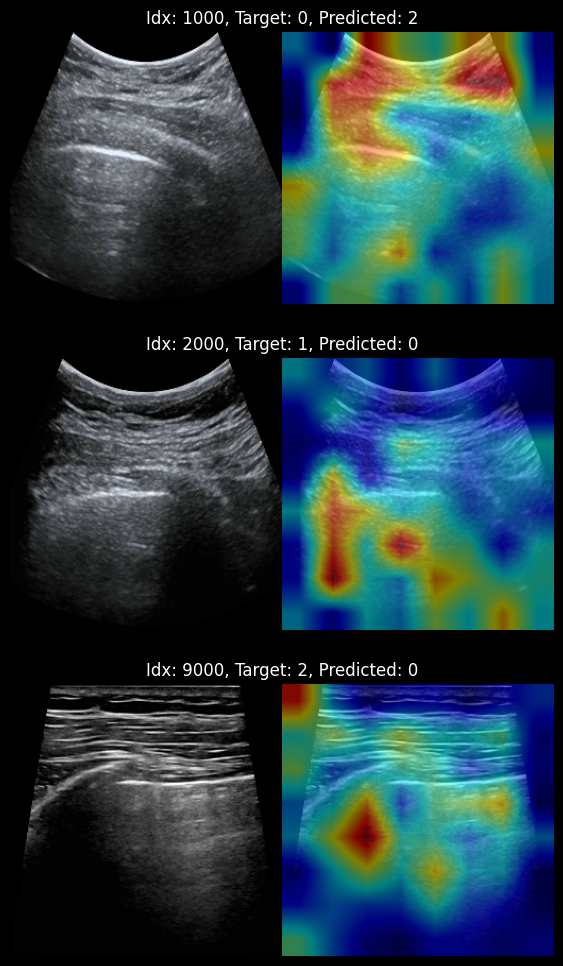

In [29]:
# List of image indices you want to display
image_indices_to_plot = [1000, 2000, 9000]
# Class to target
target_class = None


# Specify the target layers for CAM
target_layers = [model.model.final_conv]

# Create subplots for the selected images with a larger figsize

num_maps = activation_maps.size(1)  # Get the total number of activation maps
num_rows = len(image_indices_to_plot)  # Calculate the number of rows needed
num_images = len(image_indices_to_plot)
fig, axes = plt.subplots(num_rows, 1, figsize=(20, 4 * num_rows))  # Adjust the figsize as per your preference

for i, image_idx in enumerate(image_indices_to_plot):
    image = test_dataset[image_idx][0].to(device)
    displayed_image = generate_and_display_CAM(image, model, target_layers, target_class)
    
    axes[i].imshow(displayed_image)
    axes[i].set_title(f"Idx: {image_idx}, Target: {test_dataset[image_idx][1]}, Predicted: {model(image.unsqueeze(0))[0].argmax()}")
    axes[i].axis('off')
plt.show()



## Model viz Export

In [25]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter()
# writer = SummaryWriter('tb_logs\\pretrained_timm_bot/sgd/5e-05_32\\version_2')

model.trainer = trainer
writer.add_graph(model, test_dataset[image_idx][0].unsqueeze(0).to(device))
writer.close()

NameError: name 'trainer' is not defined

In [31]:
image_idx = 5000
in_size = test_dataset[image_idx][0].unsqueeze(0).shape
in_size

torch.Size([1, 3, 256, 256])

In [33]:
from torchview import draw_graph
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


In [35]:
model_graph_1 = draw_graph(
    model, input_size=in_size,
    graph_name='BoTNet',
    # roll=True,
    # hide_inner_tensors=False,
    # hide_module_functions=False,
    depth=5,
    expand_nested=True,
    graph_attrs={'fontsize': '18'},  # Set the graph font size
    node_attrs={'fontsize': '16'}   
)

RuntimeError: Failed to run torchgraph see error message


(dot.exe:12336): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


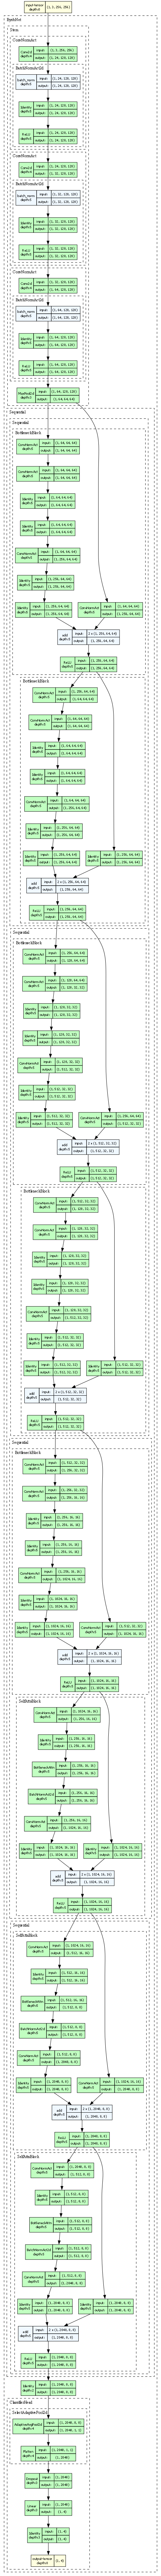

In [115]:
model_graph_1.visual_graph

# TEST

In [ ]:

image_idx = 1000
image = test_dataset[image_idx][0].to(device).unsqueeze(0)
with torch.no_grad():
    features = model(image)

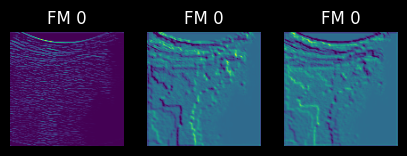

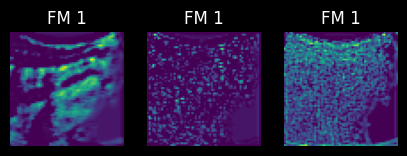

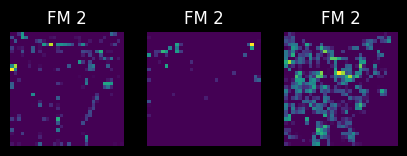

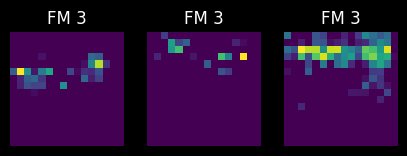

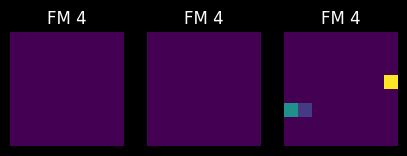

actual: 2


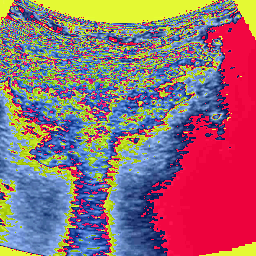

In [ ]:
image_idx = 1000

image = Image.fromarray(test_dataset[image_idx][0])

transformed_image = transforms(image)

image = torch_transforms.ToTensor()(test_dataset[image_idx][0])
image = torch_transforms.Resize((256, 256))(image)



input_img = transformed_image
pil_input = torch_transforms.ToPILImage()(input_img)

output = model(input_img.unsqueeze(0))
# Iterate through the output feature maps
for i, o in enumerate(output):
    # Assuming 'o' has shape [1, channels, height, width]

    # Convert the tensor to a NumPy array
    feature_map = o[0].cpu().detach().numpy()

    # You may want to normalize the feature map to [0, 1] for visualization
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
    plt.figure(figsize=(5, 5))
    # Create the first subplot
    plt.subplot(1, 3, 1)
    plt.imshow(feature_map[0], cmap='viridis')
    plt.title(f'FM {i}')
    plt.axis('off')

    # Create the second subplot
    plt.subplot(1, 3, 2)
    plt.imshow(feature_map[1], cmap='viridis')
    plt.title(f'FM {i}')
    plt.axis('off')

    # Create the third subplot
    plt.subplot(1, 3, 3)
    plt.imshow(feature_map[2], cmap='viridis')
    plt.title(f'FM {i}')
    plt.axis('off')

plt.show()
    
    
# print(f"predicted: {output.argmax(dim=1)}")
print(f"actual: {test_dataset[image_idx][1]}")
pil_input

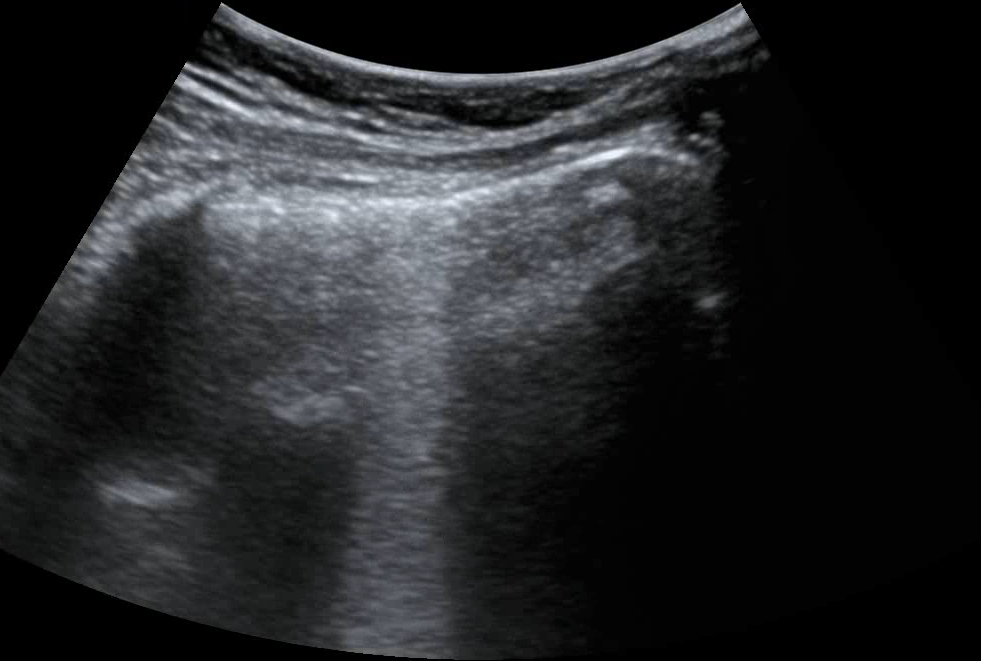

In [40]:
image

In [42]:
top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=4)
top5_probabilities, top5_class_indices

(tensor([[32.4556, 24.2118, 22.1401, 21.1925]], grad_fn=<TopkBackward0>),
 tensor([[0, 3, 2, 1]]))

### Training

In [ ]:
model.to(device)

ByobNet(
  (stem): Stem(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_dataloader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_dataloader)
            epoch_val_loss += val_loss / len(test_dataloader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/2448 [00:00<?, ?it/s]

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray